<a href="https://colab.research.google.com/github/rednevaler/hello/blob/master/Copy_of_seminar_virat_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание траекторий пешеходов

## Данные  (https://viratdata.org/ )

## Краткое описание: 
* 11 сцен со стационарных HD камер (1080p или 720p)
* 12 категорий аннотированных активностей [(описание доступно в полной документации к датасету)](https://data.kitware.com/api/v1/file/56f581c88d777f753209c9ce/download)
* Координаты коробок и описание для всех людей в сцене, а также объектов, с которыми они взаимодействуют

## Официальное описание данных

### Annotations files include three types of annotations per clip

* Event file (selected events annotated)
* Mapping file (from event to object) - <span style="color:magenta">*для самого простого способа предсказания траекторий нам нужны только объекты типа person*</span>
* Object file (all objects annotated)

The detailed formats of the above three types of (linked) files are described below.


#### Object file format

Files are named as '%s.viratdata.objects.txt'
Each line captures informabiont about a bounding box of an object (person/car etc) at the corresponding frame.
Each object track is assigned a unique 'object id' identifier. 
Note that:
- an object may be moving or static (e.g., parked car).
- an object track may be fragmented into multiple tracks.

Object File Columns
1. Object id        (a unique identifier of an object track. Unique within a file.)
2. Object duration  (duration of the object track)
3. Currnet frame    (corresponding frame number)
4. bbox lefttop x   (horizontal x coordinate of the left top of bbox, origin is lefttop of the frame)
5. bbox lefttop y   (vertical y coordinate of the left top of bbox, origin is lefttop of the frame)
6. bbox width       (horizontal width of the bbox)
7. bbox height      (vertical height of the bbox)
8. Objct Type       (object type)

Object Type ID (for column 8 above for object files)
1. person
2. car              (usually passenger vehicles such as sedan, truck)
3. vehicles         (vehicles other than usual passenger cars. Examples include construction vehicles)
4. object           (neither car or person, usually carried objects)
5. bike, bicylces   (may include engine-powered auto-bikes)




### Ссылка на датасет: https://data.kitware.com/#collection/56f56db28d777f753209ba9f/folder/56f57e748d777f753209bed7

In [0]:
import os
import re
import requests

from tqdm import tqdm_notebook as tqdm
from collections import namedtuple, defaultdict

import pandas as pd 


In [0]:
#!mkdir content
#%cd content
!mkdir data
%cd data
!mkdir annotations
!mkdir homographies
!mkdir videos_original
%cd ../..

/content/content/data
/content


In [0]:
%cd content
%ls

/content
content/  data/  sample_data/


In [0]:
#!mkdir content
%cd content
!mkdir data

/content/content


In [0]:
%cd content/data
%ls

/content/content/data
annotations/


In [0]:
!mkdir homographies

In [0]:
!touch "content/data/annotations/VIRAT_S_000001.viratdata.objects.txt"

In [0]:
%cd data
%ls

/content/data
annotations/  homographies/  videos_original/


In [0]:
%cd content/data/annotations/
!touch "VIRAT_S_000001.viratdata.objects.txt"

/content/content/data/annotations


In [0]:
def kit_folder_content(folderid, mask='', limit=500):
    api_template = 'https://data.kitware.com/api/v1/item?folderId={}&text={}&limit={}&sort=lowerName&sortdir=1'
    url = api_template.format(folderid, mask, limit)
    req = requests.get(url, allow_redirects=True)
    return req.json()


def kit_item_files(itemid, limit=50):
    api_template = 'https://data.kitware.com/api/v1/item/{}/files?limit={}&sort=name&sortdir=1'
    url = api_template.format(itemid, limit)
    req = requests.get(url, allow_redirects=True)
    return req.json()


def kit_download_files(files_json, outname, maxfiles=1):
    with open(outname, 'wb') as outh:
        for file in files_json[0:maxfiles]:
            api_template = 'https://data.kitware.com/api/v1/file/{}/download'
            url = api_template.format(file["_id"])
            req = requests.get(url, allow_redirects=True)
            for chunk in req.iter_content(chunk_size=10**6):
                outh.write(chunk)


data_dir = os.path.join(os.getcwd(), "")

virat_annotations_dir = os.path.join(data_dir, 'annotations')
virat_video_dir = os.path.join(data_dir, 'videos_original')
virat_homographies_dir = os.path.join(data_dir, 'homographies')

download_config = [
    ('5a031a5f8d777f31ac64dfd2', virat_annotations_dir, 'objects'),
    ('56f581c88d777f753209c9d2', virat_homographies_dir, ''),
]
for dir_id, dir_name, select_mask in download_config:
    try:
        os.mkdir(dir_name)
    except:
        print("could not make dir", dir_name)
        pass
    print("Downloading {}:".format(dir_name))
    for item in tqdm(kit_folder_content(dir_id, select_mask, 1000)):
        print(dir_name + "/" + item["name"])
        kit_download_files(kit_item_files(item["_id"]), dir_name[:] + "/" + item["name"])


('could not make dir', '/content/data/annotations')


/content/data/annotations/VIRAT_S_000001.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000002.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000003.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000004.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000006.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000101.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000102.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000200_00_000100_000171.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000200_01_000226_000268.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000200_02_000479_000635.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000200_03_000657_000899.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000200_04_000937_001443.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000200_05_001525_001575.viratdata.objects.txt
/content/data/annotations/VIRAT_S_000200_06_001693_001824.viratdata.objects.txt

/content/data/homographies/README_homography.txt
/content/data/homographies/VIRAT_0000_homography_img2world.png
/content/data/homographies/VIRAT_0000_homography_img2world.txt
/content/data/homographies/VIRAT_0001_homography_img2world.png
/content/data/homographies/VIRAT_0001_homography_img2world.txt
/content/data/homographies/VIRAT_0002_homography_img2world.png
/content/data/homographies/VIRAT_0002_homography_img2world.txt
/content/data/homographies/VIRAT_0100_homography_img2world.png
/content/data/homographies/VIRAT_0100_homography_img2world.txt
/content/data/homographies/VIRAT_0101_homography_img2world.png
/content/data/homographies/VIRAT_0101_homography_img2world.txt
/content/data/homographies/VIRAT_0102_homography_img2world.png
/content/data/homographies/VIRAT_0102_homography_img2world.txt
/content/data/homographies/VIRAT_0400_homography_img2world.png
/content/data/homographies/VIRAT_0400_homography_img2world.txt
/content/data/homographies/VIRAT_0401_homography_img2world.png
/conte

Для семинара вам нужны только гомографии и видео + аннотации одной сцены. 

Чтобы скачать все данные, нужно раскомментить аннотации в download_config-е.

Если вам понадобится скачать дополнительно какие-то ещё данные, то заполните конфиг по аналогии: уникальный ID папки (Folder information/Unique ID с сайта data.kitware.com), куда качать, подстрока для фильтрации файлов, если нужно

In [0]:
! mkdir -p $virat_annotations_dir 
! wget https://data.kitware.com/api/v1/item/56f57e748d777f753209bedf/download -O $virat_annotations_dir/VIRAT_S_000001.viratdata.objects.txt

# тут качается видео сцены (1.36Gb), нам оно необходимо только для отрисовки примера сцены 
# вы можете не скачивать видео и не перезапускать ячейки с отрисовкой
! mkdir -p $virat_video_dir
! wget https://data.kitware.com/api/v1/item/56f581ce8d777f753209ca44/download -O $virat_video_dir/VIRAT_S_000001.mp4

--2020-05-14 19:59:47--  https://data.kitware.com/api/v1/item/56f57e748d777f753209bedf/download
Resolving data.kitware.com (data.kitware.com)... 50.58.123.189
Connecting to data.kitware.com (data.kitware.com)|50.58.123.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7105678 (6.8M) [application/octet-stream]
Saving to: ‘/content/data/annotations/VIRAT_S_000001.viratdata.objects.txt’

/content/data/annot 100%[===================>]   6.78M  8.96MB/s    in 0.8s    

2020-05-14 19:59:48 (8.96 MB/s) - ‘/content/data/annotations/VIRAT_S_000001.viratdata.objects.txt’ saved [7105678/7105678]

--2020-05-14 19:59:53--  https://data.kitware.com/api/v1/item/56f581ce8d777f753209ca44/download
Resolving data.kitware.com (data.kitware.com)... 50.58.123.189
Connecting to data.kitware.com (data.kitware.com)|50.58.123.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1456355404 (1.4G) [application/octet-stream]
Saving to: ‘/content/data/videos_orig

In [0]:
def get_scene_id(name):
    return re.findall(r'\d{4}', name)[0]

In [0]:
def get_record_id(name):
    return re.findall(r'\d{6}', name)[0]

In [0]:
%cd data
%ls

/content/data
annotations/  homographies/  videos_original/


In [0]:
data_dir = os.path.join(os.getcwd(), "")
virat_annotations_dir = os.path.join(data_dir, 'annotations')
virat_video_dir = os.path.join(data_dir, 'videos_original')
virat_homographies_dir = os.path.join(data_dir, 'homographies')

In [0]:
os.listdir(virat_annotations_dir[:])

['VIRAT_S_010200_06_000702_000744.viratdata.objects.txt',
 'VIRAT_S_010203_04_000457_000511.viratdata.objects.txt',
 'VIRAT_S_040000_00_000000_000036.viratdata.objects.txt',
 'VIRAT_S_000201_02_000590_000623.viratdata.objects.txt',
 'VIRAT_S_010110_03_000712_000739.viratdata.objects.txt',
 'VIRAT_S_000203_08_001702_001734.viratdata.objects.txt',
 'VIRAT_S_010111_02_000198_000310.viratdata.objects.txt',
 'VIRAT_S_000200_01_000226_000268.viratdata.objects.txt',
 'VIRAT_S_010000_04_000530_000605.viratdata.objects.txt',
 'VIRAT_S_010201_04_000374_000469.viratdata.objects.txt',
 'VIRAT_S_010003_05_000499_000523.viratdata.objects.txt',
 'VIRAT_S_040103_05_000729_000804.viratdata.objects.txt',
 'VIRAT_S_000006.viratdata.objects.txt',
 'VIRAT_S_050202_00_000000_000105.viratdata.objects.txt',
 'VIRAT_S_010003_02_000165_000202.viratdata.objects.txt',
 'VIRAT_S_050201_08_001567_001647.viratdata.objects.txt',
 'VIRAT_S_010200_01_000254_000322.viratdata.objects.txt',
 'VIRAT_S_000205_01_000197_0003

In [0]:
record_id_to_video_filename = {get_record_id(fn): os.path.join(virat_video_dir, fn) for fn in os.listdir(virat_video_dir)}
record_id_to_object_annotation_filename = {get_record_id(fn): os.path.join(virat_annotations_dir[:], fn) for fn in os.listdir(virat_annotations_dir[:])}
scene_id_to_scene_homographies_filename = {get_scene_id(fn): os.path.join(virat_homographies_dir[:], fn) for fn in os.listdir(virat_homographies_dir[:]) if fn.endswith('homography_img2world.txt')}
scene_id_to_scene_homographies_imgs = {get_scene_id(fn): os.path.join(virat_homographies_dir[:], fn) for fn in os.listdir(virat_homographies_dir[:]) if fn.endswith('.png')}


In [0]:
record_id_to_object_annotation_filename

{'000001': '/content/data/annotations/VIRAT_S_000001.viratdata.objects.txt',
 '000002': '/content/data/annotations/VIRAT_S_000002.viratdata.objects.txt',
 '000003': '/content/data/annotations/VIRAT_S_000003.viratdata.objects.txt',
 '000004': '/content/data/annotations/VIRAT_S_000004.viratdata.objects.txt',
 '000006': '/content/data/annotations/VIRAT_S_000006.viratdata.objects.txt',
 '000101': '/content/data/annotations/VIRAT_S_000101.viratdata.objects.txt',
 '000102': '/content/data/annotations/VIRAT_S_000102.viratdata.objects.txt',
 '000200': '/content/data/annotations/VIRAT_S_000200_05_001525_001575.viratdata.objects.txt',
 '000201': '/content/data/annotations/VIRAT_S_000201_03_000640_000672.viratdata.objects.txt',
 '000202': '/content/data/annotations/VIRAT_S_000202_00_000000_000977.viratdata.objects.txt',
 '000203': '/content/data/annotations/VIRAT_S_000203_04_000903_001086.viratdata.objects.txt',
 '000205': '/content/data/annotations/VIRAT_S_000205_03_000860_000922.viratdata.objec

In [0]:
ObjectTypes = namedtuple('ObjectTypes', ['PERSON', 'CAR', 'VEHICLE', 'OBJECT', 'BIKE'])
virat_object_types = ObjectTypes(
    PERSON = 1,
    CAR = 2,
    VEHICLE = 3,
    OBJECT = 4,
    BIKE = 5,
)

OBJECT_ANNOTATION_FIELDS = [
    'object_id', 'object_duration', 'current_frame', 'left_top_x', 'left_top_y', 'width', 'height', 'object_type']


In [0]:
def record_id2scene_id(record_id):
    return record_id[:4]

def record_id_to_homography(record_id):
    scene_id = record_id2scene_id(record_id)
    return scene_id_to_scene_homographies_filename[scene_id], \
           scene_id_to_scene_homographies_imgs[scene_id]

In [0]:
record_id = '000001'

object_annotation_filename = record_id_to_object_annotation_filename[record_id]
scene_homography_filename, scene_homography_img = record_id_to_homography(record_id)


In [0]:
video_filename = record_id_to_video_filename[record_id]


In [0]:
# Прочитаем данные и отберём все записи с людьми
df = pd.read_csv(object_annotation_filename, delim_whitespace=True, names=OBJECT_ANNOTATION_FIELDS)
df = df[df.object_type.isin([virat_object_types.PERSON])] 


In [0]:
df.head()

,object_id,object_duration,current_frame,left_top_x,left_top_y,width,height,object_type
0,1,385,3455,1,663,76,132,1
1,1,385,3456,1,663,76,132,1
2,1,385,3457,1,663,76,132,1
3,1,385,3458,1,663,76,132,1
4,1,385,3459,1,663,76,132,1


## Посмотрим на данные глазами

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [0]:
# найдём одну из сцен с максимальным количеством людей на ней
frame_id = df.groupby(['current_frame']).size().sort_values(ascending=False).index[0]


In [0]:
def get_track(df, object_id, frame_bounds):
    df = df[df.object_id == object_id]
    if frame_bounds[0] is not None and frame_bounds[1] is not None:
        assert frame_bounds[0] <= frame_bounds[1]
        track = df[np.logical_and(df.current_frame >= frame_bounds[0], df.current_frame < frame_bounds[1])]
    elif frame_bounds[0] is not None:
        track = df[df.current_frame >= frame_bounds[0]]
    elif frame_bounds[1] is not None:
        track = df[df.current_frame < frame_bounds[1]]
    else:
        return df
    return track

In [0]:
def get_track_coordinates(track, decimation_rate=6): # https://en.wikipedia.org/wiki/Downsampling_(signal_processing)
    coords = np.concatenate([
        [np.array(track.left_top_x + track.width / 2)], 
        [np.array(track.left_top_y + track.height)]
    ]).transpose((1,0))
    coords = coords[:coords.shape[0] - coords.shape[0] % decimation_rate, :].reshape(
        (coords.shape[0] // decimation_rate, decimation_rate, coords.shape[1]))
    coords = np.median(coords, axis=1)
    return coords.astype(np.int32)


 ### Отрисуем треки на кадре из видео:

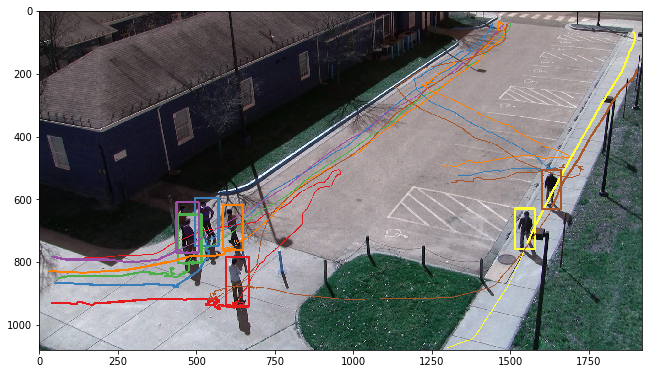

In [0]:
cap = cv2.VideoCapture(video_filename)

cap.set(1, frame_id)
ret, frame = cap.read()

img = frame.copy()
colors = [(228,26,28), (55,126,184), (77,175,74), (152,78,163), (255,127,0), (255,255,51), (166,86,40), (247,129,191)]
for i, row in enumerate(df[df.current_frame == frame_id].iterrows()):
    cv2.rectangle(
        img, 
        (row[1].left_top_x, row[1].left_top_y), 
        (row[1].left_top_x + row[1].width,row[1].left_top_y + row[1].height), 
        colors[i], 5)
    track = get_track(df, row[1].object_id, (None, row[1].current_frame))
    coords = get_track_coordinates(track)
    cv2.polylines(img, [coords], False, colors[i], 5)
    
    track = get_track(df, row[1].object_id, (row[1].current_frame, None))
    coords = get_track_coordinates(track)
    cv2.polylines(img, [coords], False, colors[i], 2)

plt.figure(figsize=(10.8, 19.2))
plt.imshow(img)
plt.show()


In [0]:
# посмотрим FPS видео, чтобы понять, сколько точек мы хотим предсказывать
cap.get(cv2.CAP_PROP_FPS)


29.97002997002997

Обычно предсказывают на 5 или 10 секунд вперёд, мы будем  предсказывать на 5 секунд вперёд по 0.4 секунды на горизонт

## Теперь нужно перевести треки в мировые координаты

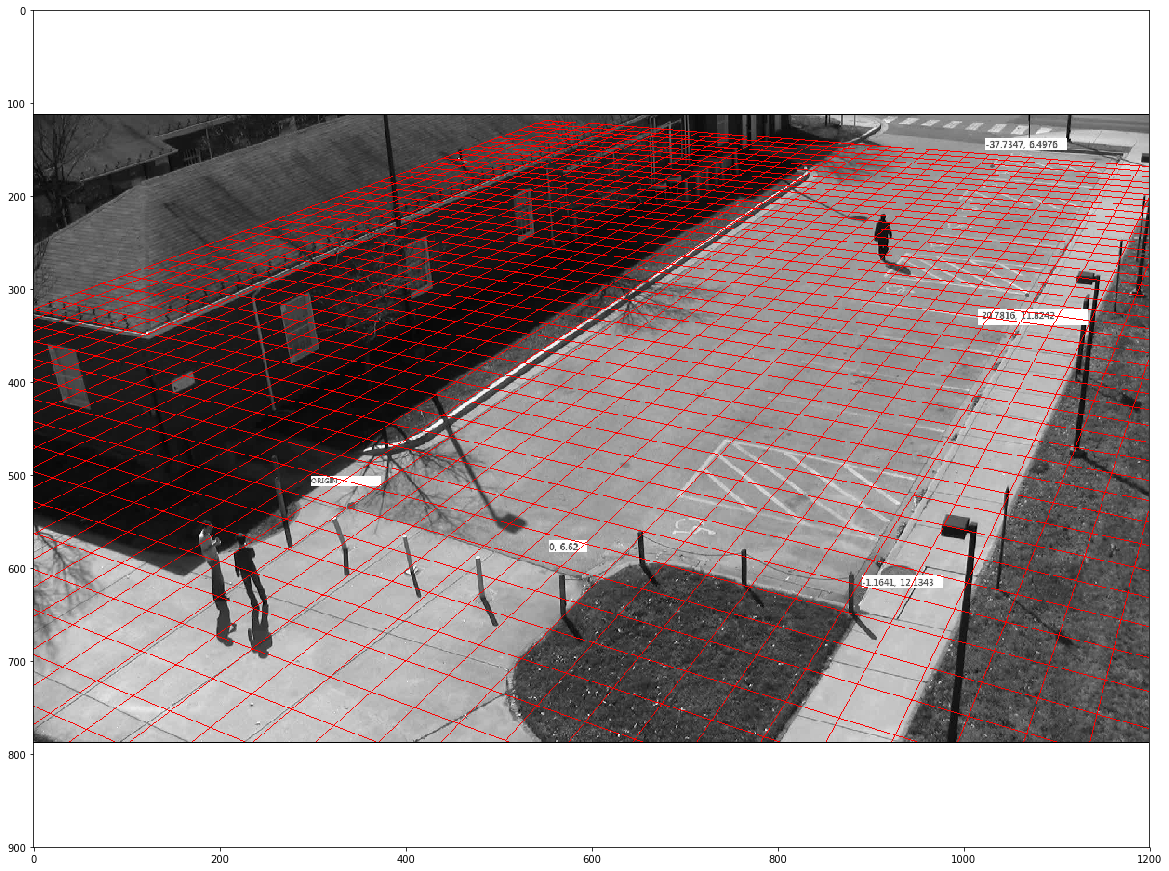

In [0]:
# отрисуем картинку, демонстрирующую нужное преобразование

plt.figure(figsize=(20, 40))
plt.imshow(cv2.imread(scene_homography_img))
plt.show()

In [0]:
# матрица гомографии нашей сцены
H = np.loadtxt(scene_homography_filename, dtype=np.float, delimiter=',')
H

array([[-2.5796104e-04,  9.3565491e-04, -4.9343613e-01],
       [ 5.7183404e-04,  8.2778391e-04, -8.6963374e-01],
       [ 1.5464549e-06,  4.0565615e-05,  1.6012838e-02]])

## Гомография

Матрица гомографии в данном контексте - это матрица проективного преобразования координат плосткости поверхности земли на изображении в bird's-eye view 

## Описание гомографии из документации

Each homography H provides a mapping from image coordinate to scene-dependent world coordinate.

$$[xw,yw,zw] = H*[xi,yi,1]$$


$xi$: horizontal axis on image with left top corner as origin, increases right. 

$yi$: vertical axis on image with left top corner as origin, increases downward.

$xw/zw$: world x coordinate

$yw/zw$: world y coordiante



In [0]:
def transform(input_xy, H):
    coords = np.ones((input_xy.shape[0], 3))
    coords[:, :2] = input_xy
    word_frame_coords = H.dot(coords.T).T
    word_frame_coords[:, 0] /= word_frame_coords[:, 2]
    word_frame_coords[:, 1] /= word_frame_coords[:, 2]
    return word_frame_coords[:, :2]


##  Нарисуем преобразованные треки и референсные точки 

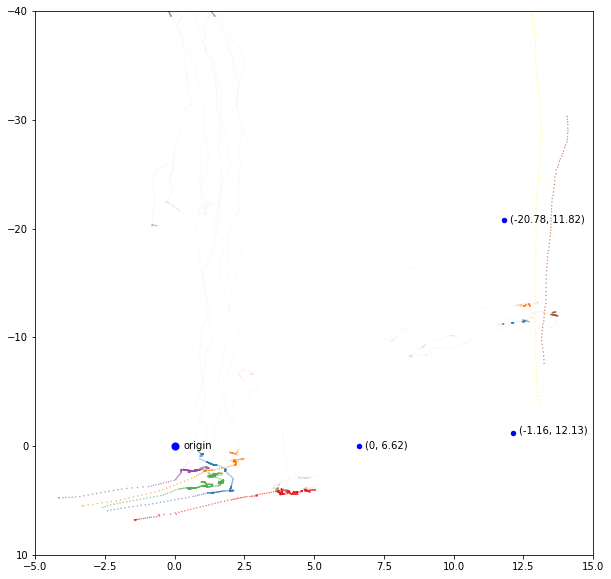

In [0]:
plt.figure(figsize=(10, 10))

for i, row in enumerate(df[df.current_frame == frame_id].iterrows()):
    track = get_track(df, row[1].object_id, (None, row[1].current_frame))
    coords = get_track_coordinates(track)
    word_frame_coords = transform(coords, H)
    plt.scatter(word_frame_coords[:, 1], word_frame_coords[:, 0], c=np.tile(colors[i], (word_frame_coords.shape[0], 1)).astype(np.float) / 255, s=0.1)
    
    track = get_track(df, row[1].object_id, (row[1].current_frame, None))
    coords = get_track_coordinates(track)
    word_frame_coords = transform(coords, H)
    plt.scatter(word_frame_coords[:, 1], word_frame_coords[:, 0], c=np.tile(colors[i], (word_frame_coords.shape[0], 1)).astype(np.float) / 255, s=0.01, alpha=0.2)

plt.xlim((-5, 15))
plt.ylim((10,-40))

plt.scatter(0, 0, c='b', s=50)
plt.annotate('origin', xy=(0, 0), xytext=(0.3, 0.3))

plt.scatter(6.62, 0, c='b', s=20)
plt.annotate('(0, 6.62)', xy=(0, 0), xytext=(6.82, 0.2))

plt.scatter(12.13, -1.16, c='b', s=20)
plt.annotate('(-1.16, 12.13)', xy=(0, 0),  xytext=(12.33, -1.16))

plt.scatter(11.82, -20.78, c='b', s=20)
plt.annotate('(-20.78, 11.82)', xy=(0, 0),  xytext=(12.02, -20.58))

plt.show()

In [0]:
record_id_to_object_annotations = dict()
for record_id, filename in record_id_to_object_annotation_filename.iteritems():
    dataframe = pd.read_csv(filename, delim_whitespace=True, names=OBJECT_ANNOTATION_FIELDS)
    if record_id in record_id_to_object_annotations:
        record_id_to_object_annotations[record_id] = pd.concat([
            record_id_to_object_annotations[record_id], dataframe
        ])
    else:
        record_id_to_object_annotations[record_id] = dataframe
        
scene_id_to_homography = dict()
for scene_id, filename in scene_id_to_scene_homographies_filename.iteritems():
    scene_id_to_homography[scene_id] = np.loadtxt(filename, dtype=np.float, delimiter=',')


In [0]:
record_id_to_object_annotation_filename

{'000001': '/content/data/annotations/VIRAT_S_000001.viratdata.objects.txt',
 '000002': '/content/data/annotations/VIRAT_S_000002.viratdata.objects.txt',
 '000003': '/content/data/annotations/VIRAT_S_000003.viratdata.objects.txt',
 '000004': '/content/data/annotations/VIRAT_S_000004.viratdata.objects.txt',
 '000006': '/content/data/annotations/VIRAT_S_000006.viratdata.objects.txt',
 '000101': '/content/data/annotations/VIRAT_S_000101.viratdata.objects.txt',
 '000102': '/content/data/annotations/VIRAT_S_000102.viratdata.objects.txt',
 '000200': '/content/data/annotations/VIRAT_S_000200_05_001525_001575.viratdata.objects.txt',
 '000201': '/content/data/annotations/VIRAT_S_000201_03_000640_000672.viratdata.objects.txt',
 '000202': '/content/data/annotations/VIRAT_S_000202_00_000000_000977.viratdata.objects.txt',
 '000203': '/content/data/annotations/VIRAT_S_000203_04_000903_001086.viratdata.objects.txt',
 '000205': '/content/data/annotations/VIRAT_S_000205_03_000860_000922.viratdata.objec

In [0]:
scene_id_to_record_ids = defaultdict(list)
for record_id in record_id_to_object_annotation_filename.keys():
    scene_id = record_id2scene_id(record_id)
    scene_id_to_record_ids[scene_id].append(record_id)

In [0]:
scene_id_to_record_ids

defaultdict(list,
            {'0000': ['000006', '000004', '000002', '000003', '000001'],
             '0001': ['000102', '000101'],
             '0002': ['000205',
              '000206',
              '000207',
              '000200',
              '000201',
              '000202',
              '000203'],
             '0100': ['010005',
              '010004',
              '010003',
              '010002',
              '010001',
              '010000'],
             '0101': ['010108',
              '010109',
              '010106',
              '010107',
              '010115',
              '010114',
              '010116',
              '010111',
              '010110',
              '010113',
              '010112'],
             '0102': ['010205',
              '010204',
              '010207',
              '010206',
              '010201',
              '010200',
              '010203',
              '010202',
              '010208'],
             '0400': ['040002',
      

## Посмотрим на статистику по сценам

Так как датасет не гарантирует нам сквозные id объектов, будем семплировать траектории внутри record_id

In [0]:
for scene_id, record_ids in sorted(scene_id_to_record_ids.iteritems()):
    for record_id in sorted(record_ids):
        print(
            "Scene %s record %s contains %3d unique objects and %7d rows in dataset" % (
                scene_id, 
                record_id, 
                len(record_id_to_object_annotations[record_id].object_id.unique()), 
                len(record_id_to_object_annotations[record_id])
            )
        )

Scene 0000 record 000001 contains  23 unique objects and  219982 rows in dataset
Scene 0000 record 000002 contains  18 unique objects and  118778 rows in dataset
Scene 0000 record 000003 contains  21 unique objects and  208594 rows in dataset
Scene 0000 record 000004 contains   9 unique objects and   24797 rows in dataset
Scene 0000 record 000006 contains  22 unique objects and   44955 rows in dataset
Scene 0001 record 000101 contains 207 unique objects and  221168 rows in dataset
Scene 0001 record 000102 contains 328 unique objects and  382177 rows in dataset
Scene 0002 record 000200 contains   0 unique objects and       0 rows in dataset
Scene 0002 record 000201 contains   2 unique objects and    1316 rows in dataset
Scene 0002 record 000202 contains  21 unique objects and  206161 rows in dataset
Scene 0002 record 000203 contains   3 unique objects and    6379 rows in dataset
Scene 0002 record 000205 contains   0 unique objects and       0 rows in dataset
Scene 0002 record 000206 con

## Разделим датасет по сценам на трейн, тест и валидацию

In [0]:
VALIDATION_SCENE_IDS = ['0000']
TEST_SCENE_IDS = ['0002']
TRAIN_SCENE_IDS = ['0100', '0101', '0102', '0001', '0400', '0401', '0500', '0502', '0503']

In [0]:
def process_track(track, H, history_length, prediction_length, decimation_rate, track_mode):
    coordinates = transform(
        get_track_coordinates(track.sort_values('current_frame'), decimation_rate=decimation_rate), H)
    if track_mode == 'diff':
        coordinates = coordinates[1:, :] - coordinates[:-1, :]
    elif track_mode == 'relative':
        coordinates = coordinates - coordinates[history_length - 1]
    elif track_mode == 'absolute':
        pass
    else:
        ValueError('Unknown mode %s' % track_mode)
    return coordinates[:history_length], coordinates[history_length:history_length+prediction_length]
        

def deterministic_data_generator(
        scene_ids, 
        history_length, prediction_length, decimation_rate, 
        batch_size=16, generator_length=None, track_mode='relative', stop_on_end=False):
    def internal_generator(scene_id, record_id):
        df = record_id_to_object_annotations[record_id]
        H = scene_id_to_homography[scene_id]
        all_object_ids = df.object_id.unique()
        if len(all_object_ids) == 0:
            return
        batch_features = []
        batch_gt = []
        generated_batches = 0
        for object_id in all_object_ids:
            full_track = get_track(df, object_id, (None, None))
            for row_id in range(0, len(full_track), history_length * decimation_rate):
                start_point = full_track.iloc[row_id]
                track = get_track(
                    df, object_id, 
                    (start_point.current_frame, 
                     start_point.current_frame + (prediction_length + history_length + 1) * decimation_rate))
                if len(track) != (prediction_length + history_length + 1) * decimation_rate:
                    continue
                X, y = process_track(track, H, history_length, prediction_length, decimation_rate, track_mode)
                batch_features.append(X)
                batch_gt.append(y)
                if len(batch_features) == batch_size:
                    yield np.concatenate([batch_features]), np.concatenate([batch_gt])
                    generated_batches += 1
                    if generator_length and generated_batches == generator_length:
                        return 
                    batch_features = []
                    batch_gt = []
    while True:
        for scene_id in scene_ids:
            for record_id in scene_id_to_record_ids[scene_id]:
                for X, y in internal_generator(scene_id, record_id):
                    yield X, y 
        if stop_on_end:
            return

def random_data_generator(
        scene_ids, 
        history_length, prediction_length, 
        batch_size, decimation_rate, track_mode='relative'):
    while True:
        scene_id = np.random.choice(scene_ids)
        record_id = np.random.choice(scene_id_to_record_ids[scene_id])
        df = record_id_to_object_annotations[record_id]
        H = scene_id_to_homography[scene_id]
        all_object_ids = df.object_id.unique()
        if len(all_object_ids) == 0:
            continue
        batch_features = []
        batch_gt = []        
        while len(batch_features) < batch_size:
            object_id = np.random.choice(all_object_ids)
            full_track = get_track(df, object_id, (None, None))
            start_point = full_track.sample(1).iloc[0]
            track = get_track(
                df, object_id, 
                (start_point.current_frame - (history_length + 1) * decimation_rate, start_point.current_frame + prediction_length * decimation_rate))
            if len(track) != (prediction_length + history_length + 1) * decimation_rate:
                continue
            X, y = process_track(track, H, history_length, prediction_length, decimation_rate, track_mode)
            batch_features.append(X)
            batch_gt.append(y)
        yield np.concatenate([batch_features]), np.concatenate([batch_gt])


In [0]:
# Зададим параметры генераторов следующим образом

# Коэффициент прореживания для достижения длины одного горизонта в 0.4 секунды 
decimation_rate = 6
# Длина доступной истории - 2.4 секунды
history_length = 6 
# Самый дальний горизонт предсказания - 5.2 секунды
prediction_length = 13 

track_mode = 'absolute'

In [0]:
test_generator = random_data_generator(TEST_SCENE_IDS, batch_size=8, history_length=history_length, prediction_length=prediction_length, decimation_rate=decimation_rate, track_mode=track_mode)

In [0]:
%%time
X, y = next(test_generator)


CPU times: user 50.3 ms, sys: 1.87 ms, total: 52.2 ms
Wall time: 58.1 ms


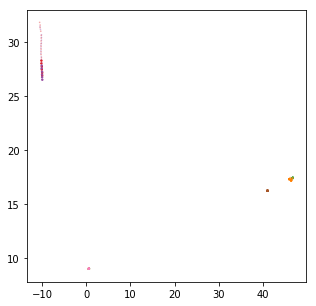

In [0]:
plt.figure(figsize=(5, 5))

for i in range(min(X.shape[0], len(colors))):
    plt.scatter(X[i, :, 1], X[i, :, 0], c=np.tile(colors[i], (X.shape[1], 1)).astype(np.float) / 255, s=2)
    plt.scatter(y[i, :, 1], y[i, :, 0], c=np.tile(colors[i], (y.shape[1], 1)).astype(np.float) / 255, s=0.5, alpha=0.3)


#  Метрики и модели

## Какие метрики принято публиковать?
* Average displacement error - mean L2 over all estimated points of a trajectory and the true points.
* $MinADE_k$ - the minimum average displacement error over k most likely trajectories.
* Final displacement error - the distance between the predicted final destination and the true final destination at end of the prediction period $T_{pred}$.
* $MinFDE_k$ - the minimum final displacement error over k most likely trajectories.
* Average non-linear displacement error - The is the MSE at the non-linear regions of a trajectory. 


## Модель без ML - фильтр Калмана

In [0]:
#kalman_xy source: https://stackoverflow.com/a/13903992

linear_motion_F = np.matrix('''
                      1. 0. 1. 0.;
                      0. 1. 0. 1.;
                      0. 0. 1. 0.;
                      0. 0. 0. 1.
                      ''')

def kalman_xy(x, P, measurement, R,
              motion = np.matrix('0. 0. 0. 0.').T,
              Q = np.matrix(np.eye(4))):
    """
    Parameters:    
    x: initial state 4-tuple of location and velocity: (x0, x1, x0_dot, x1_dot)
    P: initial uncertainty convariance matrix
    measurement: observed position
    R: measurement noise 
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    """
    return kalman(x, P, measurement, R, motion, Q,
                  F = linear_motion_F,
                  H = np.matrix('''
                      1. 0. 0. 0.;
                      0. 1. 0. 0.'''))

def kalman(x, P, measurement, R, motion, Q, F, H):
    '''
    Parameters:
    x: initial state
    P: initial uncertainty covariance matrix
    measurement: observed position (same shape as H*x)
    R: measurement noise (same shape as H)
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    F: next state function: x_prime = F*x
    H: measurement function: position = H*x

    Return: the updated and predicted new values for (x, P)

    See also http://en.wikipedia.org/wiki/Kalman_filter

    This version of kalman can be applied to many different situations by
    appropriately defining F and H 
    '''
    # UPDATE x, P based on measurement m    
    # distance between measured and current position-belief
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P

    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q
    return x, P


def kalman_pred(traj, n_out=5, R = 0.01):
    x = np.matrix('0. 0. 0. 0.').T 
    P = np.matrix(np.eye(4))*1000
    F = linear_motion_F
    for step in range(traj.shape[0]):
        x, P = kalman_xy(x, P, traj[step, :], R)
    x_out = x
    result = np.squeeze(x_out[:2], axis=1).tolist()
    for _ in range(n_out-1):
        x_out = F*x_out
        result += np.squeeze(x_out[:2], axis=1).tolist()
    return np.array(result)

def kalman_pred_batch(trajs, n_out=5, R = 0.01):
    result = []
    for traj_id in range(trajs.shape[0]):
        result += [kalman_pred(trajs[traj_id], n_out, R)]
    return np.array(result)
    

Давайте посчитаем метрики на тесте для фильтра Калмана

Для метрик не забудьте оставить размерность батча

In [0]:
def average_displacement_error(y_true, y_pred):
    # your code here
    return K.mean((y_true - y_pred) ** 2, axis=tuple(list(range(1, len(y_true.shape)))))
    
def final_displacement_error(y_true, y_pred):
    # your code here
    shape_new = (y_true.shape[0], y_true.shape[2])
    final_positions_true = (y_true[:, -1, :]).reshape(shape_new)
    final_positions_pred = (y_pred[:, -1, :]).reshape(shape_new)
    return np.sqrt((final_positions_true[:, 0] - final_positions_pred[:, 0])**2 + 
                   (final_positions_true[:, 1] - final_positions_pred[:, 1])**2)

In [0]:
predictor_function = lambda x: kalman_pred_batch(x, n_out=prediction_length)

In [0]:
def eval_on_test(
        predictor_function,
        history_length, prediction_length, 
        batch_size, decimation_rate, track_mode='relative',
        scene_ids=TEST_SCENE_IDS,
        metrics_functions=[average_displacement_error, final_displacement_error]):
    test_generator = deterministic_data_generator(scene_ids, batch_size=batch_size, history_length=history_length, prediction_length=prediction_length, decimation_rate=decimation_rate, track_mode=track_mode, stop_on_end=True)
    metrics_values = defaultdict(list)
    for X, y in tqdm(test_generator):
        prediction = predictor_function(X)
        #print(prediction.shape)
        for metrics_function in metrics_functions:
            metrics_values[metrics_function.__name__] += list(metrics_function(y, prediction))
    result = dict()
    for metrics_function in metrics_functions:
        result[metrics_function.__name__] = np.mean(metrics_values[metrics_function.__name__])
    return result

In [0]:
result = eval_on_test(predictor_function, history_length=history_length, prediction_length=prediction_length, decimation_rate=decimation_rate, batch_size=64)

In [0]:
for metric_name, metric_val in result.iteritems():
    print '%s: %.3f' % (metric_name, metric_val)

final_displacement_error: 0.262
average_displacement_error: 0.217


In [0]:
# Посмотрим на предсказания

In [0]:
track_mode = 'absolute'
test_generator = random_data_generator(TEST_SCENE_IDS, batch_size=64, history_length=history_length, prediction_length=prediction_length, decimation_rate=decimation_rate, track_mode=track_mode)

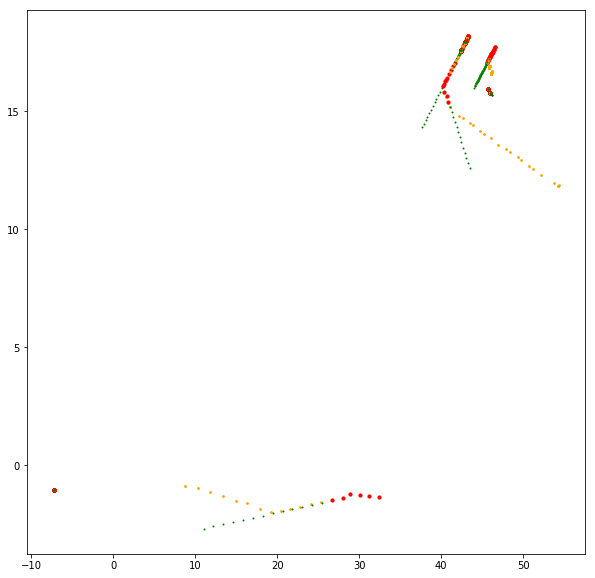

In [0]:
X, y = next(test_generator)
kalman_prediction = kalman_pred_batch(X, n_out=prediction_length)
plt.figure(figsize=(10, 10))

for i in range(0, len(X)):
    plt.scatter(X[i, :, 1], X[i, :, 0], c='r', s=10)
    plt.scatter(y[i, :, 1], y[i, :, 0], c='orange', s=3)
    plt.scatter(kalman_prediction[i, :, 1], kalman_prediction[i, :, 0], c='g', s=1)
plt.show()

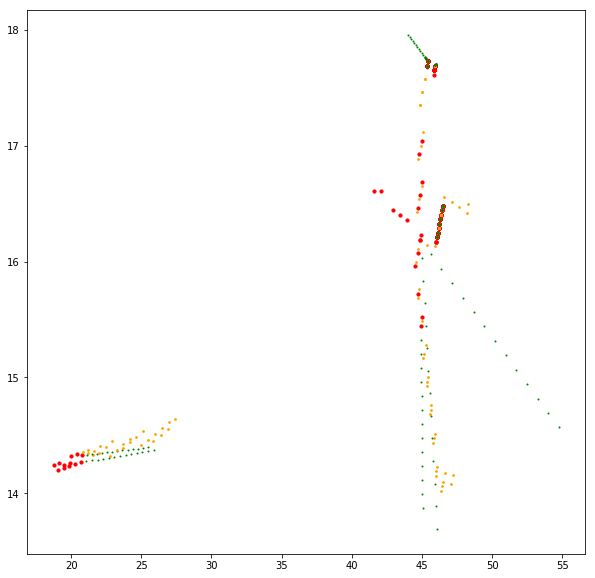

In [0]:
X, y = next(test_generator)
kalman_prediction = kalman_pred_batch(X, n_out=prediction_length)
plt.figure(figsize=(10, 10))

for i in range(0, len(X)):
    plt.scatter(X[i, :, 1], X[i, :, 0], c='r', s=10)
    plt.scatter(y[i, :, 1], y[i, :, 0], c='orange', s=3)
    plt.scatter(kalman_prediction[i, :, 1], kalman_prediction[i, :, 0], c='g', s=1)
plt.show()

## Какие модели мы будем обсуждать и где почитать подробнее?
* #### Peeking into the Future: Predicting Future Person Activities and Locations in Videos (CVPR 2019)
    - https://arxiv.org/abs/1902.03748 - ссылка на статью
    - https://github.com/google/next-prediction - ссылка на код
  
* #### Social LSTM: Human Trajectory Prediction in Crowded Spaces (CVPR 2016)
    - http://openaccess.thecvf.com/content_cvpr_2016/papers/Alahi_Social_LSTM_Human_CVPR_2016_paper.pdf - ссылка на статью
* #### Social GAN: Socially Acceptable Trajectories with Generative Adversarial Networks (CVPR 2019)
    - https://arxiv.org/abs/1803.10892 - ссылка на статью
    - https://github.com/agrimgupta92/sgan - ссылка на код
* #### SoPhie: An Attentive GAN for Predicting Paths Compliant to Social and Physical Constraints
    - https://arxiv.org/pdf/1806.01482.pdf - ссылка на статью

In [0]:
def deterministic_data_generator_dl(
        scene_ids, 
        history_length, prediction_length, decimation_rate, 
        batch_size=16, generator_length=None, track_mode='relative', stop_on_end=False):
    def internal_generator(scene_id, record_id):
        df = record_id_to_object_annotations[record_id]
        H = scene_id_to_homography[scene_id]
        all_object_ids = df.object_id.unique()
        if len(all_object_ids) == 0:
            return
        batch_features = []
        batch_gt = []
        generated_batches = 0
        for object_id in all_object_ids:
            full_track = get_track(df, object_id, (None, None))
            for row_id in range(0, len(full_track), history_length * decimation_rate):
                start_point = full_track.iloc[row_id]
                track = get_track(
                    df, object_id, 
                    (start_point.current_frame, 
                     start_point.current_frame + (prediction_length + history_length + 1) * decimation_rate))
                if len(track) != (prediction_length + history_length + 1) * decimation_rate:
                    continue
                X, y = process_track(track, H, history_length, prediction_length, decimation_rate, track_mode)
                batch_features.append(X)
                batch_gt.append(y)
                if len(batch_features) == batch_size:
                    yield np.concatenate([batch_features]), np.concatenate([batch_gt])
                    generated_batches += 1
                    if generator_length and generated_batches == generator_length:
                        return 
                    batch_features = []
                    batch_gt = []
    while True:
        for scene_id in scene_ids:
            for record_id in scene_id_to_record_ids[scene_id]:
                for X, y in internal_generator(scene_id, record_id):
                    yield X, y 
        if stop_on_end:
            return

def random_data_generator_dl(
        scene_ids, 
        history_length, prediction_length, 
        batch_size, decimation_rate, track_mode='relative'):
    while True:
        scene_id = np.random.choice(scene_ids)
        record_id = np.random.choice(scene_id_to_record_ids[scene_id])
        df = record_id_to_object_annotations[record_id]
        H = scene_id_to_homography[scene_id]
        all_object_ids = df.object_id.unique()
        if len(all_object_ids) == 0:
            continue
        batch_features = []
        batch_gt = []        
        while len(batch_features) < batch_size:
            object_id = np.random.choice(all_object_ids)
            full_track = get_track(df, object_id, (None, None))
            start_point = full_track.sample(1).iloc[0]
            track = get_track(
                df, object_id, 
                (start_point.current_frame - (history_length + 1) * decimation_rate, start_point.current_frame + prediction_length * decimation_rate))
            if len(track) != (prediction_length + history_length + 1) * decimation_rate:
                continue
            X, y = process_track(track, H, history_length, prediction_length, decimation_rate, track_mode)
            batch_features.append(X)
            batch_gt.append(y)
        yield np.concatenate([batch_features]), np.concatenate([batch_gt])

### Шаблон для обучения модели

In [0]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K


In [0]:
track_mode = 'relative'
batch_size = 64

In [0]:
import tensorflow.keras.layers as L

6

In [256]:
model = keras.models.Sequential()
model.add(L.Dense(64, input_shape=(history_length, 2), batch_size=batch_size))
model.add(L.LSTM(128))
model.add(L.RepeatVector(13))
model.add(L.LSTM(128, return_sequences=True))
model.add(L.TimeDistributed(L.Dense(2), name='decoder_result'))

# your code 
'''output_layer = L.Dense(2)(enc_outputs)#keras.layers.TimeDistributed(keras.layers.Dense(2), name='decoder_result')(enc_outputs)
output_layer.shape'''

"output_layer = L.Dense(2)(enc_outputs)#keras.layers.TimeDistributed(keras.layers.Dense(2), name='decoder_result')(enc_outputs)\noutput_layer.shape"

In [0]:
model = keras.Model(inputs=[input_layer, input_dec], outputs=[output_layer])

In [0]:
! mkdir -p models

In [0]:
import keras.backend as K

def my_mse(y_true, y_pred):
    return K.mean(K.sqrt((y_true[..., 0] - y_pred[..., 0]) ** 2 + (y_true[..., 0] - y_pred[..., 0]) ** 2))

In [0]:
model.compile(
    optimizer='adam', 
    metrics=[average_displacement_error],#, final_displacement_error], 
    loss=average_displacement_error#'mse'#my_mse
    # params
)

In [0]:
validation_steps = 50

train_generator = random_data_generator(TRAIN_SCENE_IDS, batch_size=batch_size, history_length=history_length, prediction_length=prediction_length, track_mode=track_mode, decimation_rate=decimation_rate)
val_generator = deterministic_data_generator(VALIDATION_SCENE_IDS, generator_length=validation_steps, batch_size=batch_size, history_length=history_length, prediction_length=prediction_length, track_mode=track_mode, decimation_rate=decimation_rate)


In [0]:
!pip3 install catboost
from catboost import class CatBoostRegressor
train_data

In [0]:
model.fit_generator(
    train_generator, steps_per_epoch=100, # your choice, 
    validation_data=val_generator, validation_steps=validation_steps, epochs=50
    # params
)

W0515 01:22:41.923258 140248114284416 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0515 01:22:42.195746 140248114284416 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 100 steps, validate for 50 steps
Epoch 1/50
100/100 [==============================] - 68s 678ms/step - loss: 11.1794 - average_displacement_error: 11.1794 - val_loss: 0.3336 - val_average_displacement_error: 0.3336
Epoch 2/50
 41/100 [===========>..................] - ETA: 29s - loss: 5.9083 - average_displacement_error: 5.9083

In [0]:
predictor_function = lambda x: model.predict(x)

In [227]:
result = eval_on_test(predictor_function, history_length=history_length, prediction_length=prediction_length, decimation_rate=decimation_rate, batch_size=64)

In [228]:
for metric_name, metric_val in result.iteritems():
    print '%s: %.3f' % (metric_name, metric_val)

final_displacement_error: 0.519
average_displacement_error: 0.268


In [253]:
X, y = next(test_generator)
kalman_prediction = kalman_pred_batch(X, n_out=prediction_length)
model_prediction = model.predict(X)
y_true = np.array(y)
np.mean((y_true - model_prediction) ** 2, axis=tuple(list(range(1, len(y_true.shape)))))

array([1669.82607754, 1591.36806551, 1677.78016257, 1687.00704175,
       1676.83520853, 1604.780397  , 1662.22336147, 1649.43322984,
       1649.43322984, 1677.78016257,  716.35030909, 1645.78052884,
       1666.09190736,  821.01368083, 1668.25661096, 1669.82607754,
       1594.07475832, 1662.22336147, 1672.21460005, 1649.43322984,
       1692.36098789, 1649.43322984, 1669.85752197, 1674.82701447,
       1692.36098789, 1649.43322984, 1677.78016257, 1645.78052884,
       1677.31291322, 1688.58964461, 1825.22317575, 1796.32554075,
       1649.43322984, 1674.07170542, 1684.66245505, 1677.16011068,
       1687.59305006, 1649.43322984, 1879.94326055, 1676.03230479,
       1669.83625658, 1591.14203966, 1683.2445717 , 1644.84570684,
       1649.43322984, 1692.36098789, 1669.66437407, 1653.88198858,
       1669.82607754, 1674.07170542, 1673.59788539, 1669.82607754,
       1645.78052884, 1675.32848336, 1692.36098789, 1645.78052884,
       1677.78016257, 1677.78016257, 1682.33038881, 1781.36405

In [239]:
y_true = np.array(y)
np.mean((y_true - model_prediction) ** 2, axis=tuple(list(range(1, len(y_true.shape)))))

array([1701.5384051 ,  240.84121523,  278.31888341, 1683.66525699,
        188.91801952, 1365.68076926,  488.64974527,  517.53753727,
        410.26111583,  436.2577905 , 1494.8351456 ,  188.91801952,
        435.03078327, 1250.47644405,  809.73542832,  363.20368972,
        332.47330708, 1946.14580712,  327.13085908,  303.38725268,
       2282.81566797,  334.28276324, 1324.79880162, 1501.58038776,
        435.03078327,  306.13704712,  355.28508077,  300.60098375,
        476.44763654,  517.53753727, 1495.91355855,  517.53753727,
        270.12502349,  417.60348485,  240.84121523,  417.60348485,
        659.63052606, 1660.9671402 ,   80.07930558,  270.9386325 ,
        287.09200276, 1386.36976426,  353.53299435,  843.49985726,
        573.07389093,  497.5514771 , 1263.72717591,  353.53299435,
       1700.54221578,  517.53753727,  741.0678062 ,  188.91801952,
        305.04851651,  300.68238312,  311.9520017 , 1683.66525699,
        240.84121523,  353.53299435, 1490.34885217,  330.05875

In [238]:
tuple(list(range(1, len(y_true.shape)))), y_true.shape

((1, 2), (1, 13, 2))

In [234]:
average_displacement_error(y[0], model_prediction[0])

AttributeError: ignored

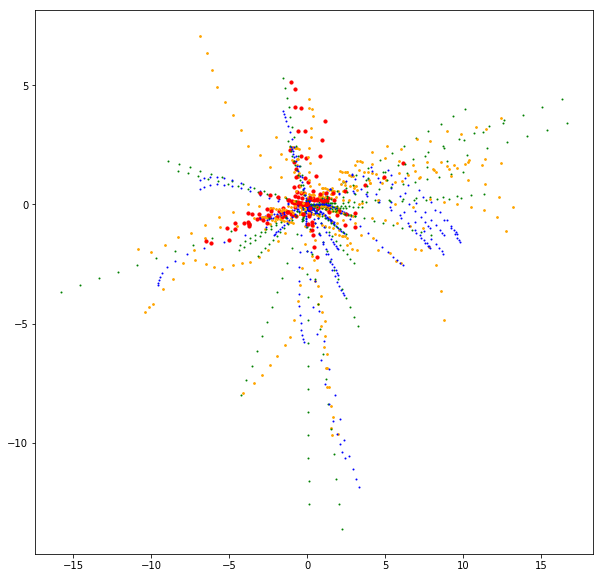

In [252]:
X, y = next(train_generator)
kalman_prediction = kalman_pred_batch(X, n_out=prediction_length)
model_prediction = model.predict(X)
plt.figure(figsize=(10, 10))

for i in range(0, len(X)):
    plt.scatter(X[i, :, 1], X[i, :, 0], c='r', s=10)
    plt.scatter(y[i, :, 1], y[i, :, 0], c='orange', s=3)
    plt.scatter(kalman_prediction[i, :, 1], kalman_prediction[i, :, 0], c='g', s=1)
    plt.scatter(model_prediction[i, :, 1], model_prediction[i, :, 0], c='b', s=1)
plt.show()

In [0]:
model.load_weights('models/best_model.h5')

## Задание
1. Реализуйте ml-модель предсказания траектории и обучите до сходимости любым удобным вам способом (суммарно 4 балла)
    * модель сошлась и предсказывает не рандомные траектории (1 балл)
    * это нейросетевая модель (1 балл)
    * нарисуйте 5-10 примеров предсказания, где модель визуально и по метрикам ведёт себя лучше фильтра Калмана (2 балла)    
2. Посчитайте метрики: ADE и FDE по сценам, ADE и FDE для траекторий без стоящих пешеходов по сценам (2 балла)

3. Используйте любой дополнительный фактор, доступный в датасете, или идею из статьи (2 балла)
    * модель обыгрывает предыдущий пункт на тесте по всем метрикам из пункта 2 (+2 балла)

4. Модель обыгрывает фильтр Калмана на тесте (3 балла)

По итогам этого задания ожидается читаемый отчёт с текстовыми комментариями, метриками на тесте, примерами предсказания. Результаты, не вошедшие в отчёт в финальной оценке засчитаны не будут. 

Максимально - 10 баллов за задание. Выбирайте сами, что вам будет интереснее реализовать